# Production Voronoi-Based Pu-Cl Cluster Analysis

This notebook implements the complete analysis pipeline for Pu-Cl cluster systems using Voronoi tessellation from OVITO.

## Overview

This analysis pipeline includes:
1. Voronoi tessellation using OVITO
2. Weighted coordination analysis
3. Shared-anion network construction
4. Oligomer characterization
5. Temporal stability analysis

See `spec.md` for detailed specification.


In [1]:
# All imports
import glob
import numpy as np
import matplotlib.pyplot as plt

# OVITO imports
from ovito.io import import_file

# Local utility imports
from utils import (
    get_pipeline_info,
    extract_particle_properties,
    # Phase 2: Voronoi Tessellation
    apply_voronoi_analysis,
    extract_voronoi_bonds,
    extract_voronoi_particle_properties,
    compute_voronoi_face_areas,
    perform_voronoi_tessellation,
    # Phase 3: Weighted Coordination Analysis
    compute_weighted_coordination_analysis,
    build_coordination_histograms,
)

# Plotting imports
from plots import setup_plot_style, plot_coordination_histograms, plot_weighted_coordination_comparison


In [2]:
# Configure your input structure/trajectory file
input_path = '/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.67/T1000K/dump.lammpstrj' # TODO: Set path, e.g., '/pscratch/sd/p/pvashi/irp/irp_mace_l_2/irp/density/NaCl-PuCl3/x0.67/T900K/dump.lammpstrj'

# Analysis parameters (will be used in later phases)
MIN_AREA_PERCENT = 0.0  # Minimum area threshold as percent of total
USE_RADII = False  # Whether to use atomic radii for Voronoi tessellation

print("Configuration loaded")

Configuration loaded


## Data Loading

Load trajectory file and extract basic pipeline information.


In [3]:
# Load trajectory file using OVITO
if input_path is not None:
    # Load with OVITO pipeline
    pipeline = import_file(input_path, multiple_frames=True)
    print(f"Loaded trajectory with {pipeline.source.num_frames} frames")
    
    # Choose frame index (use last frame by default)
    frame = pipeline.source.num_frames - 1
    
    # Get basic pipeline information using utils
    info = get_pipeline_info(pipeline)
    print("\nPipeline Information:")
    print(f"  Number of frames: {info['num_frames']}")
    print(f"  Number of particles: {info['num_particles']}")
    print(f"  Species: {info['species']}")
    
    # Display cell information from utils
    if info['cell_info']:
        cell_info = info['cell_info']
        print("\nCell Information:")
        if cell_info.get('matrix') is not None:
            print("  Cell matrix:")
            print(np.array(cell_info['matrix']))
        print(f"  PBC: {cell_info.get('pbc', 'N/A')}")
    
    # Set up standardized plotting style
    setup_plot_style()
    print("\nStandardized plotting style configured")
else:
    print("input_path not set. Please configure the trajectory file path above.")
    pipeline = None
    frame = None


Loaded trajectory with 23355 frames

Pipeline Information:
  Number of frames: 23355
  Number of particles: 1920
  Species: ['Pu', 'Na', 'Cl']

Cell Information:
  Cell matrix:
[[38.87808063  0.          0.          0.41085104]
 [ 0.         38.87808063  0.          0.41085104]
 [ 0.          0.         38.87808063  0.41085104]]
  PBC: (True, True, True)

Standardized plotting style configured


## Basic Pipeline Info Extraction

Extract and display particle properties from a specific frame.


In [4]:
# Extract data from chosen frame
if pipeline is not None and frame is not None:
    frame_data = pipeline.compute(frame)
    properties = extract_particle_properties(frame_data)
    
    print(f"Frame {frame} Properties:")
    print(f"  Positions shape: {properties['positions'].shape if properties['positions'] is not None else 'N/A'}")
    print(f"  Species shape: {properties['species'].shape if properties['species'] is not None else 'N/A'}")
    if properties['species'] is not None:
        unique_species = np.unique(properties['species'])
        print(f"  Unique species in frame: {unique_species}")
    print(f"  Cell matrix shape: {properties['cell_matrix'].shape if properties['cell_matrix'] is not None else 'N/A'}")
    print(f"  Periodic boundary conditions: {properties['pbc']}")
else:
    print("Pipeline not loaded. Please load a trajectory file first.")

Frame 23354 Properties:
  Positions shape: (1920, 3)
  Species shape: (1920,)
  Unique species in frame: ['Cl' 'Na' 'Pu']
  Cell matrix shape: (3, 4)
  Periodic boundary conditions: (True, True, True)


## Phase 2: Voronoi Tessellation

Apply VoronoiAnalysisModifier with generate_bonds=True and extract results.


In [5]:
# Perform Voronoi tessellation

voronoi_results = perform_voronoi_tessellation(
    pipeline=pipeline,
    frame=frame,
    use_radii=USE_RADII,
    edge_threshold=0.0,
    compute_surface_mesh=False,
)

# Extract results
data = voronoi_results['data']
bonds = voronoi_results['bonds']
particle_props = voronoi_results['particle_properties']
face_areas = voronoi_results['face_areas']


In [6]:
print(face_areas)

[2.45085643 9.88884706 0.04083762 ... 3.45192002 2.40525424 0.34273955]


In [7]:
print('face_areas',len(face_areas),'bonds',len(bonds['pairs']))

face_areas 14175 bonds 14175


## Phase 3: Weighted Coordination Analysis

Compute area-weighted (CN_A) and solid-angle-weighted (CN_Ω) coordination numbers, and build coordination histograms for Pu with different neighbor types.


In [8]:
# Compute weighted coordination analysis (includes topological, area-weighted, and solid-angle-weighted)
coordination_results = compute_weighted_coordination_analysis(
    data=data,
    bonds=bonds,
    particle_properties=particle_props,
    face_areas=face_areas,
    center_species='Pu'
)

# Extract results
cn_topological_all = coordination_results['cn_topological_all']
cn_a_all = coordination_results['cn_a_all']
cn_omega_all = coordination_results['cn_omega_all']
histograms = coordination_results['histograms']
positions = coordination_results['positions']
species = coordination_results['species']
pairs = bonds['pairs']

print("Weighted coordination analysis completed")
print(f"  Number of Pu atoms analyzed: {len(cn_a_all['atom_indices'])}")
print(f"\nTopological CN (all neighbors) - mean: {np.mean(cn_topological_all['cn_values']):.3f}, std: {np.std(cn_topological_all['cn_values']):.3f}")
print(f"CN_A (all neighbors) - mean: {np.mean(cn_a_all['cn_values']):.3f}, std: {np.std(cn_a_all['cn_values']):.3f}")
print(f"CN_Ω (all neighbors) - mean: {np.mean(cn_omega_all['cn_values']):.3f}, std: {np.std(cn_omega_all['cn_values']):.3f}")


Weighted coordination analysis completed
  Number of Pu atoms analyzed: 384

Topological CN (all neighbors) - mean: 10.438, std: 1.312
CN_A (all neighbors) - mean: 6.879, std: 1.388
CN_Ω (all neighbors) - mean: 5.437, std: 1.550


In [9]:
cn_a_all['cn_values']

array([ 7.66387598,  7.01650985,  7.62179238,  9.06547127,  5.46182754,
        7.99948632,  7.62254495,  4.62910919,  7.42363505,  6.18454348,
        6.47722166,  8.15015393,  5.53618809,  6.56507855,  5.69318185,
        6.42080028,  7.73390714,  4.45433876,  5.67617735,  6.1387487 ,
        6.0131194 ,  8.04593458,  9.81246155,  9.19635858,  8.67915915,
        4.40215366,  4.56260619,  8.06023574,  7.93650502,  9.80160716,
        6.07499551,  6.18807653,  6.44670541,  6.6646476 ,  7.41490596,
        5.90408092,  8.57464989,  5.63620734, 10.76706476,  6.11585878,
        6.903678  ,  5.97411347,  6.92380302,  5.45357304,  8.89862438,
        7.10214547,  7.10266795,  8.05658055,  6.7458376 ,  8.29786282,
        6.15735508,  5.01940002,  6.0069443 ,  6.62376535,  8.23700195,
        7.10907793,  5.35575183,  7.77318909,  8.16820803,  5.67710321,
        5.92809534,  8.54508713,  6.21645403,  5.86519295,  6.57331365,
        6.39581024,  3.86315746,  5.31211974,  7.29589364,  6.30

In [10]:
# Build histograms with different coordination types
histograms_topological = build_coordination_histograms(
    pairs, species, center_species='Pu', coordination_type='topological'
)

histograms_area = build_coordination_histograms(
    pairs, species, center_species='Pu', coordination_type='area',
    positions=positions, face_areas=face_areas
)

histograms_solid_angle = build_coordination_histograms(
    pairs, species, center_species='Pu', coordination_type='solid_angle',
    positions=positions, face_areas=face_areas
)

print("Histograms built for all coordination types")

Histograms built for all coordination types


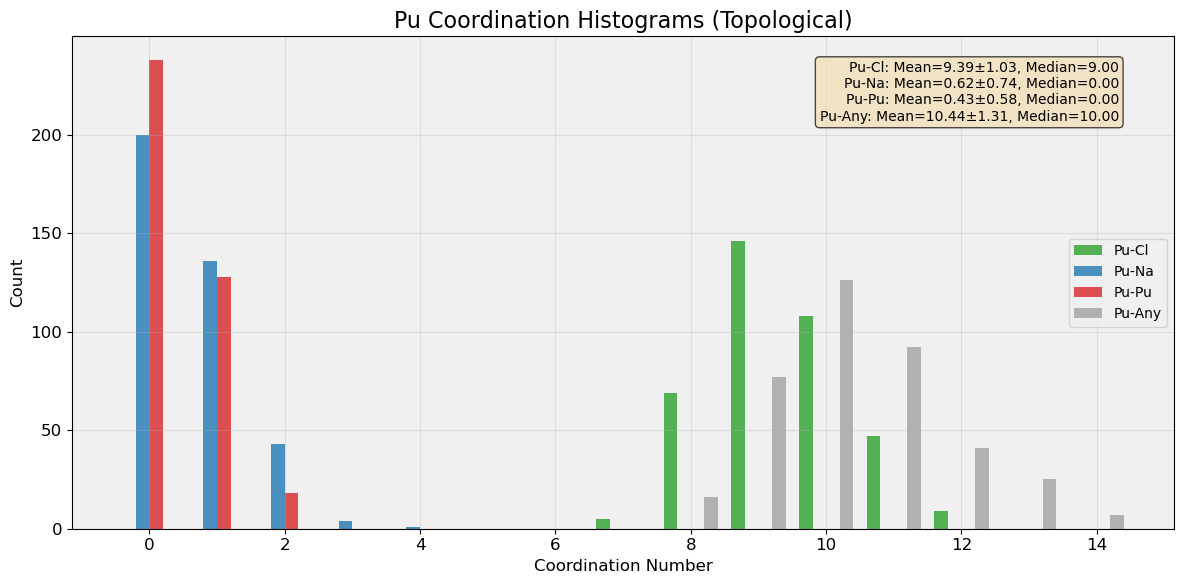

In [11]:
# Visualize coordination histograms - Topological
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_coordination_histograms(histograms_topological, ax=ax, title='Pu Coordination Histograms')
plt.tight_layout()
plt.show()


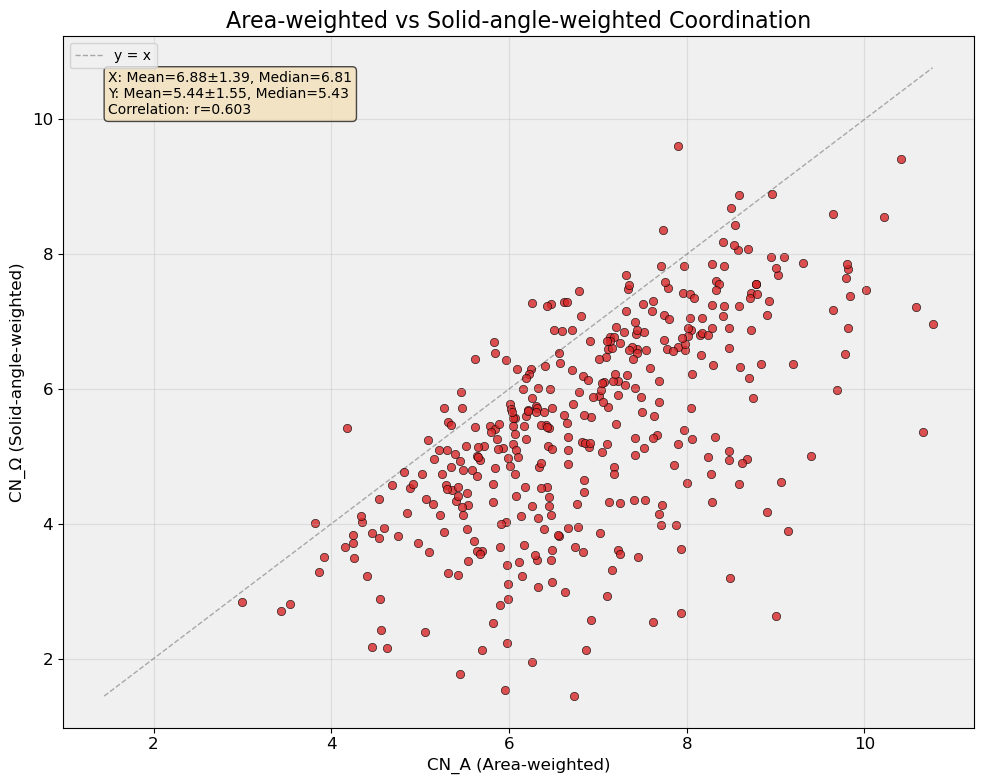

In [12]:
# Visualize CN_A vs CN_Ω comparison with statistics
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_weighted_coordination_comparison(
    cn_a_all, cn_omega_all, species, ax=ax,
    x_label='CN_A (Area-weighted)', y_label='CN_Ω (Solid-angle-weighted)',
    title='Area-weighted vs Solid-angle-weighted Coordination'
)
plt.tight_layout()
plt.show()
